In [2]:
import fns
from fns import *
from fns.functionsTFhardbound import *
%matplotlib inline

today = datetime.date.today()
todayStr = '%04d%02d%02d' % (today.year, today.month, today.day)
# todayStr = '20151005'
DIRECTORY = os.path.expanduser("~/Dropbox/0000_PhD/figures/"+todayStr+"/")
CSV_DIR_TODAY = os.path.expanduser("~/Dropbox/0000_PhD/csv/"+todayStr+"/")
CSV_DIR = os.path.expanduser("~/Dropbox/0000_PhD/csv/")
FIG_DIR = os.path.expanduser("~/Dropbox/0000_PhD/figures/")
if not os.path.exists(DIRECTORY):
    os.makedirs(DIRECTORY)
    
# from bokeh.io import output_notebook
# from bokeh.plotting import figure, show, output_file
# output_notebook()
from IPython.display import clear_output, Image, display

********************************************************************************
functionsTFhardbound loaded!
********************************************************************************


In [3]:
PAPER = os.path.expanduser('~/Dropbox/ICL-2014/Presentations/2016-10-11-GJ-sync-paper/figures/')

In [4]:
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
# matplotlib.rc("font", family="Times")

## Colors

In [5]:
N1 = '#65CBFF'
N2 = '#9595C9'

In [12]:
tauv, sG, N, T, nu = 15, 200, 2000, 20000, 50
ratio = 0.2
rasterPath = "../data/rasters/rasterPlast-tauv-%d_g-%d_N-%d_T-%d_k-%d_r-%.2f_dt-0.1" % (tauv, 
                                                                                 sG, N, T, nu, ratio)
r = np.load(rasterPath)
varPath = "../data/rasters/rastervarPlast-tauv-%d_g-%d_N-%d_T-%d_k-%d_r-%.2f_dt-0.1" % (tauv, 
                                                                                 sG, N, T, nu, ratio)
var = np.load(varPath)

## DEBUG INSTABILITY

(0.0, 1000.0)

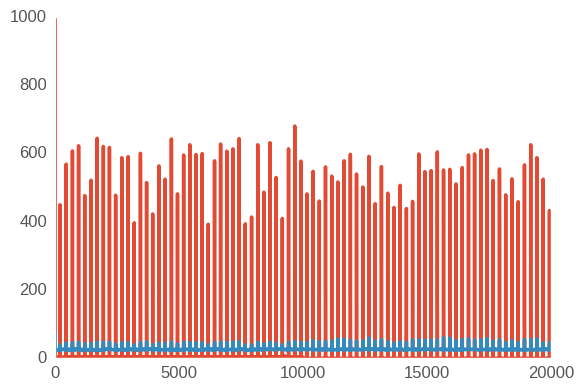

In [13]:
v = var['vvmN1']
plt.plot(v)
plt.plot(var['i1N1'])
plt.ylim()

39.9920015997 13.2904733396


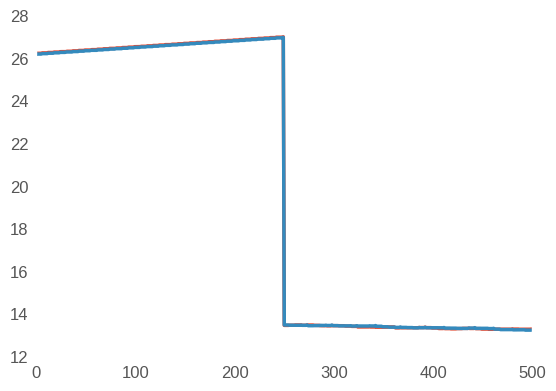

In [17]:
plt.plot(var['g1N1'])
plt.plot(var['g1N2'])
signal = np.array(v)
f_val, p_val = maxPowerFreq(signal[int(signal.shape[0] / 2):], 0.1 / 1000)
print(f_val, p_val)

(-200, 200)

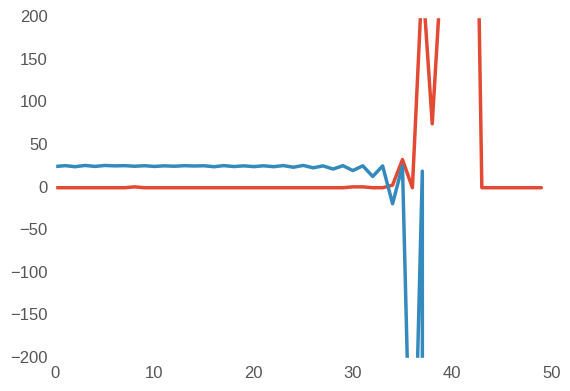

In [6]:
v = var['vvmN1']
plt.plot(v[16300:16350])
plt.plot(var['i1N1'][16300:16350])
plt.ylim([-200,200])

## dt = 0.1

In [42]:
g = 20
N = 2000
T = 1000
nu = 50
sG = 200
tauv = 45
gpu1 = TfConnEvolveNet(N=N,
                  T=T,
                  disp=False,
                  tauv=tauv,
                  device='/gpu:0',
                  spikeMonitor=True,
                  g0=g,
                  startPlast = 0,
                  nu = nu,
                  NUM_CORES = 56,
                  both=True,
                 sG = sG,
                      memfraction = 0.5
                      )
# gpu.input = apple
gpu1.dt = 0.1
gpu1.debug = True
gpu1.connectTime=0
gpu1.FACT = 50
gpu1.ratio = 1
gpu1.runTFSimul()


13.80



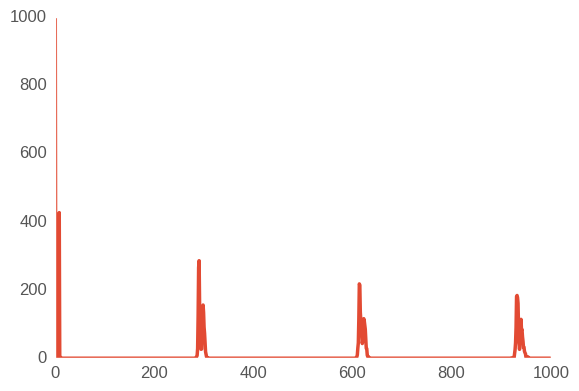

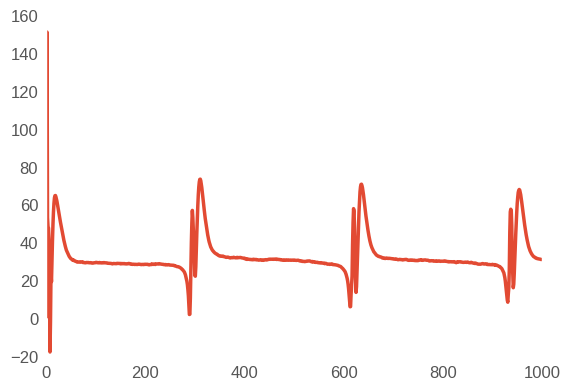

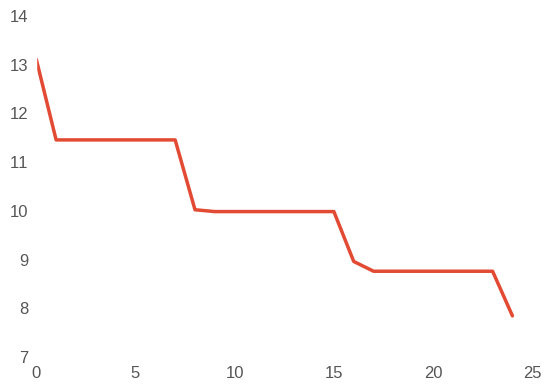

In [43]:
plt.plot(gpu1.vvmN1)
plt.figure()
plt.plot(gpu1.i1)
plt.figure()
plt.plot(gpu1.gammaN1)

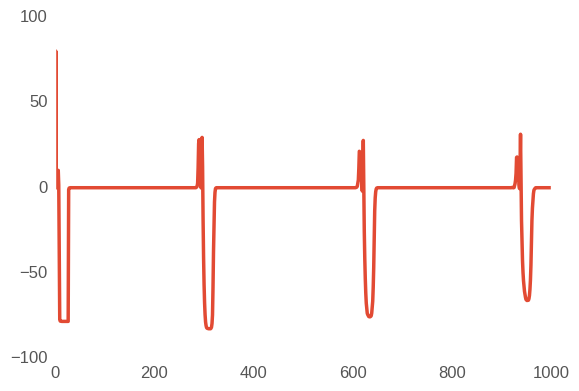

In [44]:
plt.plot(gpu1.dwcontrol[0:1000])

In [38]:
## dt = 1

In [48]:
g = 20
N = 2000
T = 100
nu = 50
sG = 200
tauv = 45
gpu = TfConnEvolveNet(N=N,
                  T=T,
                  disp=False,
                  tauv=tauv,
                  device='/gpu:0',
                  spikeMonitor=True,
                  g0=g,
                  startPlast = 0,
                  nu = nu,
                  NUM_CORES = 56,
                  both=True,
                 sG = sG,
                      memfraction = 0.5
                      )
# gpu.input = apple
gpu.dt = 1
gpu.debug = True
gpu.connectTime=0
gpu.FACT = 50
gpu.ratio = 1
gpu.runTFSimul()


2.12



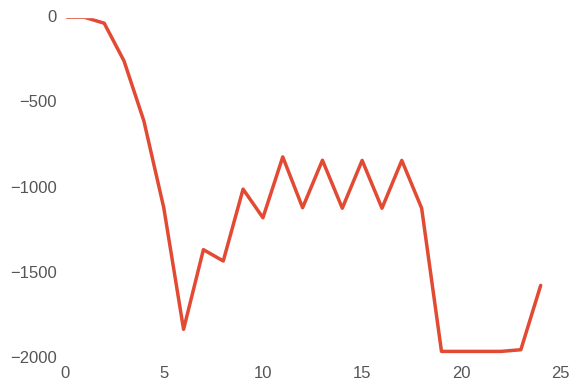

In [51]:
plt.plot(gpu.dwcontrol[0:25])

(0, 25)

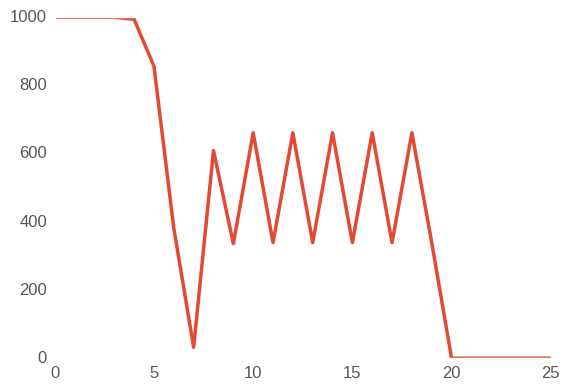

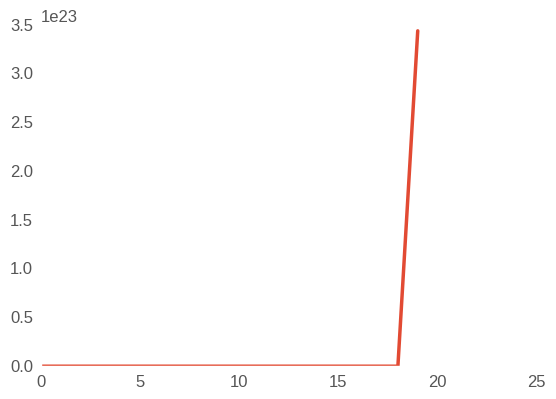

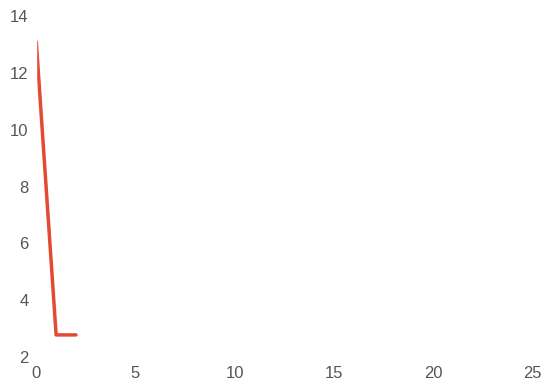

In [52]:
plt.plot(gpu.vvmN1)
plt.xlim([0,25])
plt.figure()
plt.plot(gpu.i1)
plt.xlim([0,25])

plt.figure()
plt.plot(gpu.gammaN1)
plt.xlim([0,25])



In [85]:
class Izh:
    def __init__(self, T=3000, tauv=15):
        self.bTh = 1.5
        self.u_, self.v_, self.p_, self.lowsp_, self.vv_, self.gamma_ = [], [], [], [], [], []
        self.alphaLTD = 4.7e-6
        self.T = T
        self.tauv = tauv
        self.dt = 0.25
        # stimulation
        
        
    def sim(self):
        dt = self.dt
        v = -70
        u, lowsp, p = 0, 0, 0
        gamma = 10
        self.I = [300 if (i*dt)%500<50 else -82 for i in range(int(self.T/dt))]
        for i in range(int(self.T/dt)):
            # voltage
            try:
                v = v + dt / self.tauv * ((v+60) * (v+50) - 20 * u + 8 * self.I[i])
            except:
                print(i)
                print(len(self.I))
            # adaptation
            u = u + dt * 0.044 * (v+55 - u)
            # spike
            vv = v> 25
            # reset
            v = vv * -40 + (1-vv)*v
            u = u + vv * 50
            # burst
            lowsp = lowsp + dt/8.0 * (vv * 8.0/dt - lowsp)
            p = lowsp>self.bTh
            gamma += p*(-self.alphaLTD)
            # save stuffs
            self.lowsp_.append(lowsp)
            self.p_.append(p)
            self.v_.append(v)
            self.u_.append(u)
            self.vv_.append(vv)
            self.gamma_.append(gamma)


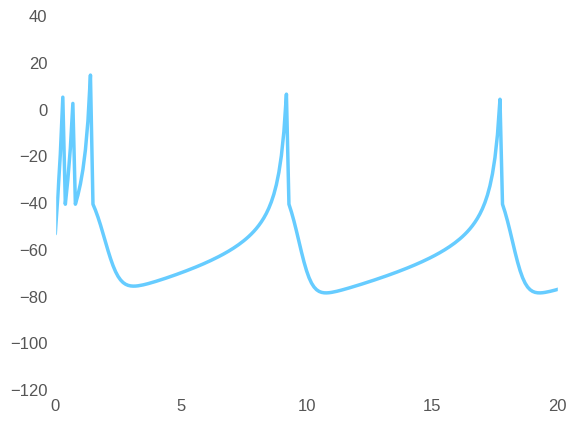

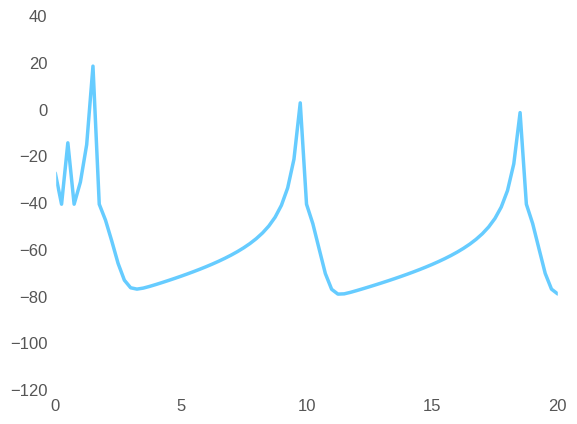

In [87]:
fig = plt.figure(figsize=(6,4.5))
izh = Izh(T=6000)
izh.dt = 0.1
izh.sim()
T = izh.T
t = np.arange(int(T/izh.dt))*izh.dt
plt.plot(t,izh.v_, label='membrane voltage [mV]', color="#66ccff")
plt.xlim([0,20])
plt.tight_layout()

fig = plt.figure(figsize=(6,4.5))
izh = Izh(T=6000)
izh.dt = 0.25
izh.sim()
T = izh.T
t = np.arange(int(T/izh.dt))*izh.dt
plt.plot(t,izh.v_, label='membrane voltage [mV]', color="#66ccff")
plt.xlim([0,20])
plt.tight_layout()